# Deep Learning PBMC Clustering Comparison

Goal: Compare clustering on PBMC data in order to regress bioinformatician bias 

https://eleozzr.github.io/desc/tutorial.html
DESC - The goal of this tool is to automatically identify the proper number of clusters within your single cell data according to the samples biological heterogeneity 

Nevertheless, the main parameter that determines the number of clusters identified is the resolution of the clustering algorithm (typically louvain or leiden). A high resolution will identify a large number of clusters and a low resolution will identify a low number of clusters. 

Consequently, we will incrementally iterate over the entire range of possible resolutions and compare the results because Control and scCLEAN. 



In [1]:
import desc as desc
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
sc.set_figure_params(dpi=200, color_map = 'viridis_r')
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.7.2
sinfo       0.3.4
-----
2f7ece400a652629565c523b34ee61b04afa385c    NA
PIL                                         8.4.0
absl                                        NA
appnope                                     0.1.2
astunparse                                  1.6.3
backcall                                    0.2.0
cached_property                             1.5.2
certifi                                     2020.06.20
cffi                                        1.15.0

# Control

In [138]:
#input the cellranger output h5ad file from alignment to the full transcriptome
adata = desc.read_h5ad('raw_files/FUll_transcriptome/Control_not_masked_filtered_feature_bc_matrix.h5ad')
adata.var_names_make_unique()
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 11714 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [140]:
#perform simple, standard QC
sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 230 cells that have less than 200 genes expressed
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 15194 genes that are detected in less than 3 cells
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [142]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [143]:
adata.obs

n_counts  n_genes  percent_mito
AAACCCAAGAACGTGC-1    4529.0     1306      0.036211
AAACCCAAGACAGTCG-1    4158.0     1724      0.078163
AAACCCAAGGACAACC-1    5419.0     1666      0.026020
AAACCCAAGGTTTGAA-1    6235.0     1952      0.071532
AAACCCAAGTTAACGA-1    3315.0     1527      0.085370
...                      ...      ...           ...
TTTGTTGTCCACGGGT-1   10859.0     2888      0.067502
TTTGTTGTCGAGGCAA-1    1654.0      830      0.220677
TTTGTTGTCGAGTCCG-1    5177.0     1306      0.025304
TTTGTTGTCGTTCAGA-1    3541.0     1450      0.097995
TTTGTTGTCTTCGACC-1    5712.0     1604      0.034664

[11484 rows x 3 columns]

In [144]:
#determine the proper thresholds according to the 99% of the data
per_cell_metrics = adata.obs
quantile = pd.DataFrame()
quantile = per_cell_metrics.quantile(0.99, numeric_only=True)
quantile

n_counts        18648.920000
n_genes          4176.700000
percent_mito        0.122461
Name: 0.99, dtype: float64

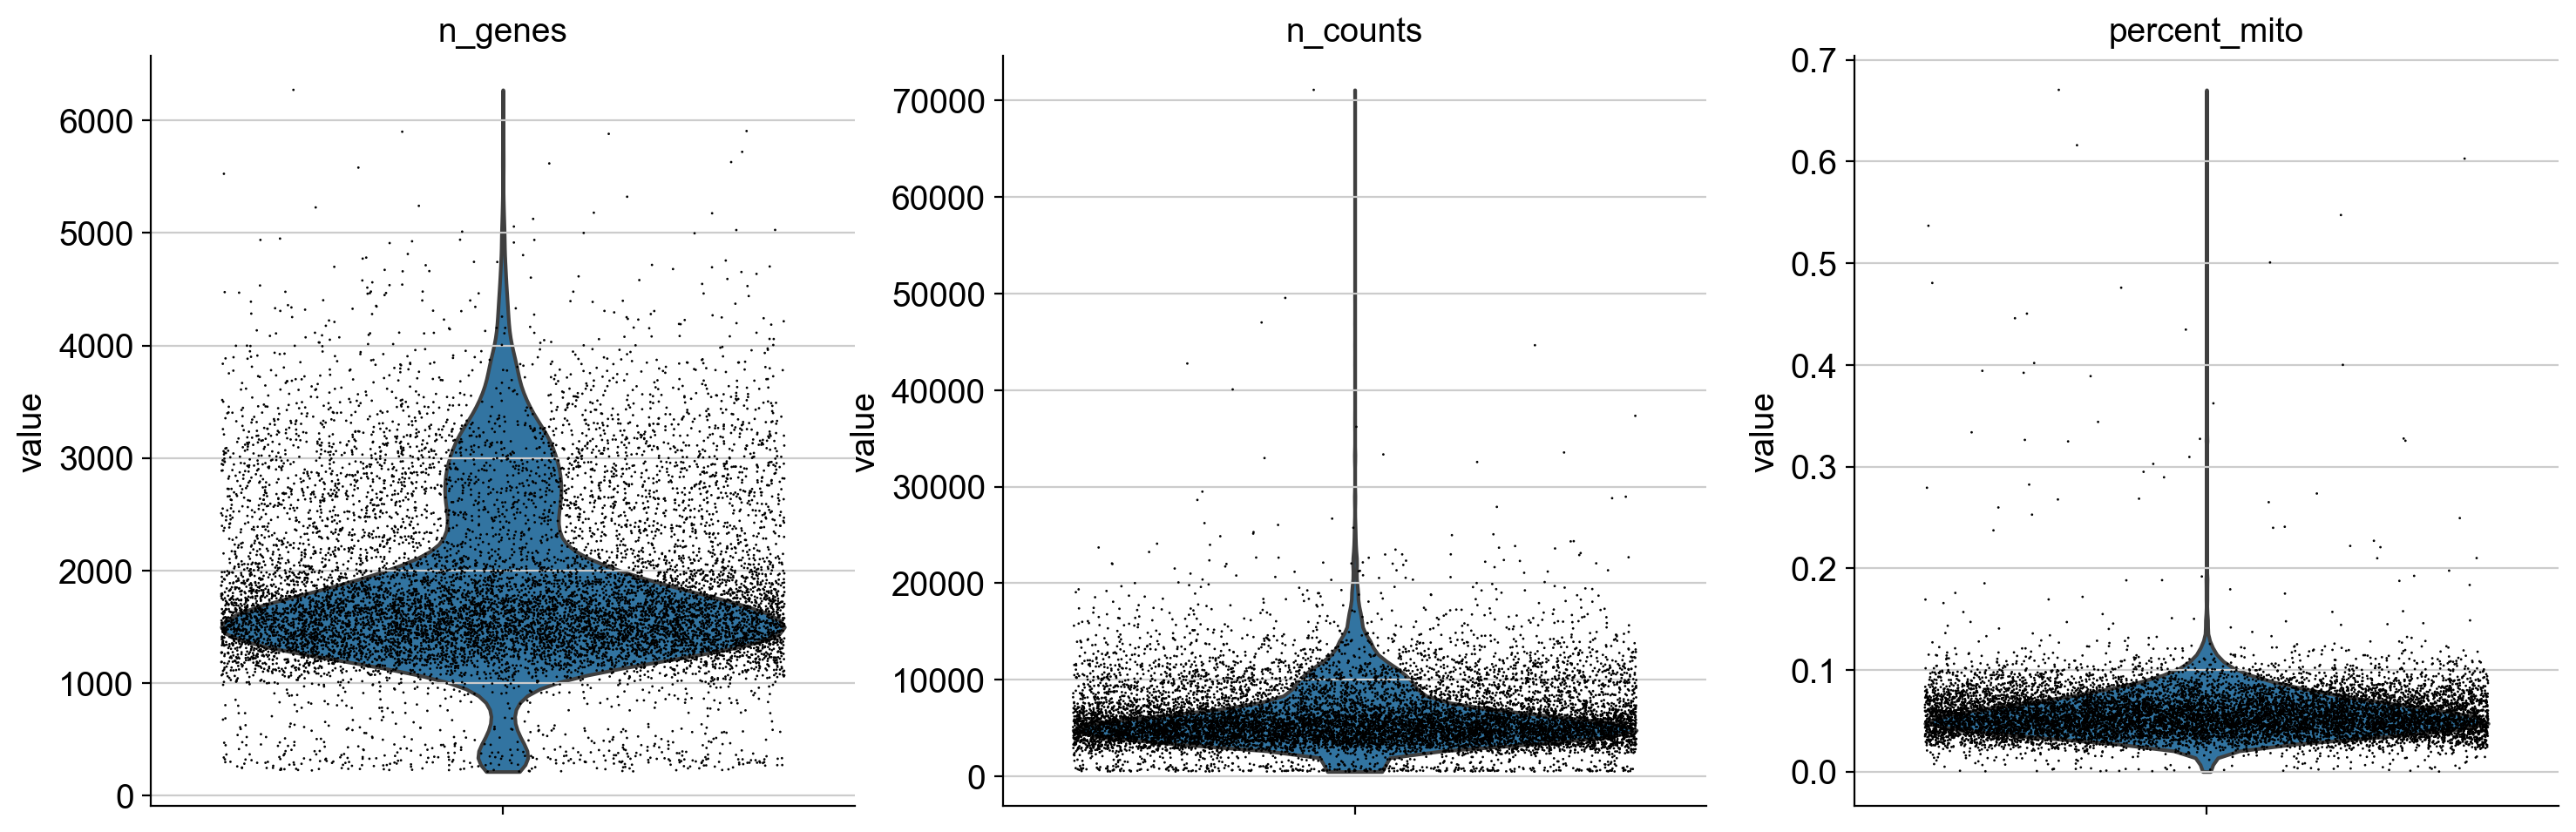

In [145]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True)

In [146]:
#filter thresholds from 99% 
adata = adata[adata.obs['n_counts'] < 18648.92, :]
adata

View of AnnData object with n_obs × n_vars = 11369 × 21407
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [147]:
desc.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
Trying to set attribute `.obs` of view, copying.
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [148]:
desc.log1p(adata)

In [149]:
adata.raw=adata

In [150]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, subset=True)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [151]:
#According to DESC tutorial, recomends performing analysis on highly variable genes
adata = adata[:, adata.var['highly_variable']]

In [152]:
adata

View of AnnData object with n_obs × n_vars = 11369 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [153]:
#the data has to be standardized prior to DESC
desc.scale(adata, zero_center=True, max_value=3)

/Users/jbezney/opt/anaconda3/envs/DESC/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [29]:
#loop through the deep learning model and append the total number of clusters identified
#check the total number of clusters according to the resolution with which it was identified
resolution_x = [0.1,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
total_clusters = []
for value in resolution_x:
    adata = desc.train(adata, dims=[adata.shape[1], 128, 32], tol=0.001, n_neighbors=10,
                   batch_size=256, louvain_resolution=[value], do_tsne=True, learning_rate=300,
                   do_umap=True, num_Cores_tsne=4)
    df_cluster = pd.DataFrame(adata.obs['desc_'+str(value)])
    df_cluster = len(df_cluster.iloc[:,0].unique())
    total_clusters.append(df_cluster)

Start to process resolution= 0.1
The number of cpu in your computer is 12

Create the directory:result_tmp to save result
Checking whether result_tmp/ae_weights.h5  exists in the directory
The file ae_weights.h5 is not exits
Pretraining the 1th layer...
learning rate = 0.1
Epoch 1/50
45/45 [==============================] - 1s 6ms/step - loss: 0.5051
Epoch 2/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4777
Epoch 3/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4559
Epoch 4/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4424
Epoch 5/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4326
Epoch 6/50
45/45 [==============================] - 0s 6ms/step - loss: 0.4241
Epoch 7/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4169
Epoch 8/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4113
Epoch 9/50
45/45 [==============================] - 0s 8ms/step - loss: 0.4064
Epoch 10/50
45/

45/45 [==============================] - 0s 7ms/step - loss: 0.3730
Epoch 48/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3730
Epoch 49/50
45/45 [==============================] - 0s 7ms/step - loss: 0.3729
Epoch 50/50
45/45 [==============================] - 0s 7ms/step - loss: 0.3730
learning rate = 0.001
Epoch 1/50
45/45 [==============================] - 1s 7ms/step - loss: 0.3730
Epoch 2/50
45/45 [==============================] - 0s 7ms/step - loss: 0.3731
Epoch 3/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3730
Epoch 4/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3729
Epoch 5/50
45/45 [==============================] - 0s 7ms/step - loss: 0.3730
Epoch 6/50
45/45 [==============================] - 0s 7ms/step - loss: 0.3730
Epoch 7/50
45/45 [==============================] - 0s 7ms/step - loss: 0.3729
Epoch 8/50
45/45 [==============================] - 0s 7ms/step - loss: 0.3731
Epoch 9/50
45/45 [====================

45/45 [==============================] - 0s 5ms/step - loss: 0.3550
Epoch 28/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3550
Epoch 29/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3550
Epoch 30/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3550
Epoch 31/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3550
Epoch 32/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3550
Epoch 33/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3549
Epoch 34/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3549
Epoch 35/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3549
Epoch 36/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3549
Epoch 37/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3549
Epoch 38/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3549
Epoch 39/50
45/45 [==============================] -

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


The value of delta_label of current 1 th iteration is 0.01627231946521242 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0628
Epoch 2/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0462
Epoch 3/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0385
Epoch 4/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0328
Epoch 5/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0283
The value of delta_label of current 2 th iteration is 0.029905884422552556 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1122
Epoch 2/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0890
Epoch 3/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0722
Epoch 4/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0597
Epoch 5/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0502
The value of delta_label of current 3 th iter

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 6)                 192       
Total params: 277,344
Trainable params: 277,344
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=0.1)is: 104.78796601295471


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:30)
computing neighbors


tsne finished and added X_tsne0.1  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap0.1  into the umap coordinates (adata.obsm)

The run time for all resolution is: 136.38761711120605
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11369 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1'
    obsp: 'distances', 'connectivities'
Start to process resolution= 0.2
The number of cpu in your computer is 12
Checking whether result_tmp/ae_weights.h5  exists in the directory
Pretraining time is 0.016122102737426758


computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


The value of delta_label of current 1 th iteration is 0.03465564253672267 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0789
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0624
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0538
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0470
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0414
The value of delta_label of current 2 th iteration is 0.019614741841850646 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1356
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1126
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0948
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0811
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0704
The value of delta_label of current 3 th iter

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The final prediction cluster is:
0    3383
1    2129
2    1575
3    1619
4     773
5     419
6     317
7     147
8    1007
dtype: int64
The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 9)                 288       
Total params: 277,440
Trainable params: 277,440
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=0.2)is: 16.52

    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:29)
computing neighbors


tsne finished and added X_tsne0.2  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap0.2  into the umap coordinates (adata.obsm)

The run time for all resolution is: 47.07176899909973
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11369 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2'
    obsp: 'distances', 'connectivities'
Start to process resolution= 0.4
The number of cpu in your computer is 12
Checking whether result_tmp/ae_weights.h5  exists in the directory
Pretraining time is 0.017837047576904297


computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.032456680446829096 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0789
Epoch 2/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0624
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0539
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0470
Epoch 5/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0414
The value of delta_label of current 2 th iteration is 0.01970270032544639 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 2ms/step - loss: 0.1355
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1126
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0948
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0811
Epoch 5/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0704
The value of delta_label of current 3 th iter

The final prediction cluster is:
0    3358
1    2129
2    1577
3    1636
4     773
5     419
6     316
7     147
8    1014
dtype: int64


computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 9)                 288       
Total params: 277,440
Trainable params: 277,440
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=0.4)is: 16.41282367706299


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:29)
computing neighbors


tsne finished and added X_tsne0.4  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap0.4  into the umap coordinates (adata.obsm)

The run time for all resolution is: 47.394776821136475
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11369 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4'
    obsp: 'distances', 'connectivities'
Start to process resolution= 0.6
The number of cpu in your computer is 12
Checking whether result_tmp/ae_weights.h5  exists in the directory
Pretraining time is 0.013768911361694336


computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.06420969302489225 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0842
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0677
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0592
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0522
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0464
The value of delta_label of current 2 th iteration is 0.025507960242765415 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1465
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1233
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1050
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0905
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0788
The value of delta_label of current 3 th iter

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                320       
Total params: 277,472
Trainable params: 277,472
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=0.6)is: 13.11959195137024


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:29)
computing neighbors


tsne finished and added X_tsne0.6  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap0.6  into the umap coordinates (adata.obsm)

The run time for all resolution is: 43.96219491958618
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11369 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6'
    obsp: 'distances', 'connectivities'
Start to process resolution= 0.8
The number of cpu in your computer is 12
Checking whether result_tmp/ae_weights.h5  exists in the directory
Pretraining time is 0.014747142791748047


computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


The value of delta_label of current 1 th iteration is 0.052159380772275485 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0894
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0730
Epoch 3/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0641
Epoch 4/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0568
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0507
The value of delta_label of current 2 th iteration is 0.021110036062978274 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 2ms/step - loss: 0.1482
Epoch 2/5
45/45 [==============================] - 0s 2ms/step - loss: 0.1251
Epoch 3/5
45/45 [==============================] - 0s 2ms/step - loss: 0.1071
Epoch 4/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0931
Epoch 5/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0821
The value of delta_label of current 3 th ite

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 11)                352       
Total params: 277,504
Trainable params: 277,504
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=0.8)is: 13.096119165420532


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:29)
computing neighbors


tsne finished and added X_tsne0.8  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap0.8  into the umap coordinates (adata.obsm)

The run time for all resolution is: 43.638885736465454
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11369 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6', 'desc_0.8'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6', 'prob_matrix0.8'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6', 'X_Embeded_z0.8', 'X_tsne0.8', 'X_umap0.8'
    obsp: 'distances', 'connectivities'
Start to process resolution= 1.0
The number of cpu in your computer is 12
Checking whether result_tmp/ae_weights.h5  exi

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


The value of delta_label of current 1 th iteration is 0.06711232298355177 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0996
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0831
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0737
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0660
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0594
The value of delta_label of current 2 th iteration is 0.03632685372504178 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1611
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1407
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1239
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1101
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0988
The value of delta_label of current 3 th itera

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso



The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 13)                416       
Total params: 277,568
Trainable params: 277,568
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=1.0)is: 13.499810934066772


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:29)
computing neighbors


tsne finished and added X_tsne1.0  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap1.0  into the umap coordinates (adata.obsm)

The run time for all resolution is: 44.50366282463074
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11369 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6', 'desc_0.8', 'desc_1.0'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6', 'prob_matrix0.8', 'prob_matrix1.0'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6', 'X_Embeded_z0.8', 'X_tsne0.8', 'X_umap0.8', 'X_Embeded_z1.0', 'X_tsne1.0', 'X_umap1.0'
    obsp: 'distances', 'connectivities'
Start to process resolution= 1.2
The number of 

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


The value of delta_label of current 1 th iteration is 0.06632069663119008 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0996
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0831
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0738
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0661
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0595
The value of delta_label of current 2 th iteration is 0.03606297827425455 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1608
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1406
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1238
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1101
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0987
The value of delta_label of current 3 th itera

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 13)                416       
Total params: 277,568
Trainable params: 277,568
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=1.2)is: 14.362415790557861


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:31)
computing neighbors


tsne finished and added X_tsne1.2  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap1.2  into the umap coordinates (adata.obsm)

The run time for all resolution is: 46.85865616798401
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11369 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6', 'desc_0.8', 'desc_1.0', 'desc_1.2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6', 'prob_matrix0.8', 'prob_matrix1.0', 'prob_matrix1.2'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6', 'X_Embeded_z0.8', 'X_tsne0.8', 'X_umap0.8', 'X_Embeded_z1.0', 'X_tsne1.0', 'X_umap1.0', 'X_Embeded_z1.2', 'X_tsne1.2', 'X_umap1.2'
    obsp: 'di

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.07590817134312604 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1028
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0867
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0775
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0701
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0638
The value of delta_label of current 2 th iteration is 0.04116457032280763 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1653
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1461
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1301
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1168
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1057
The value of delta_label of current 3 th itera

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The final prediction cluster is:
0     2349
1     1666
2     1563
3     1168
4      352
5      884
6      444
7      388
8      978
9      334
10     283
11      47
12      94
13     162
14     657
dtype: int64
The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 15)                480       
Total params: 277,632
Trainable params: 277,632
Non-trainable params: 0
_______________________________

    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:30)
computing neighbors


tsne finished and added X_tsne1.4  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap1.4  into the umap coordinates (adata.obsm)

The run time for all resolution is: 48.980205059051514
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11369 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6', 'desc_0.8', 'desc_1.0', 'desc_1.2', 'desc_1.4'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6', 'prob_matrix0.8', 'prob_matrix1.0', 'prob_matrix1.2', 'prob_matrix1.4'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6', 'X_Embeded_z0.8', 'X_tsne0.8', 'X_umap0.8', 'X_Embeded_z1.0', 'X_tsne1.0', 'X_umap1.0', 'X_Embeded_z1.2', 'X_tsne

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.10255959187263612 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1060
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0897
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0807
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0733
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0670
The value of delta_label of current 2 th iteration is 0.05602955405048817 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1711
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1519
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1359
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1227
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1115
The value of delta_label of current 3 th itera

Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2655
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2625
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2600
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2574
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2550
delta_label  0.0002638754507872284 < tol  0.001
Reached tolerance threshold. Stop training.


computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The final prediction cluster is:
0     2170
1     1272
2     1149
3     1231
4      418
5      895
6     1132
7      445
8      386
9      996
10     334
11     285
12     359
13      27
14     173
15      82
16      15
dtype: int64
The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 17)                544       
Total params: 277,696
Trainable params: 277,696
Non-trainable params: 0
________

    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:30)
computing neighbors


tsne finished and added X_tsne1.6  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap1.6  into the umap coordinates (adata.obsm)

The run time for all resolution is: 51.01515197753906
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11369 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6', 'desc_0.8', 'desc_1.0', 'desc_1.2', 'desc_1.4', 'desc_1.6'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6', 'prob_matrix0.8', 'prob_matrix1.0', 'prob_matrix1.2', 'prob_matrix1.4', 'prob_matrix1.6'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6', 'X_Embeded_z0.8', 'X_tsne0.8', 'X_umap0.8', 'X_Embeded_z1.0', 'X_tsne1.0', 'X_umap1.

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.1493535051455713 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1115
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0957
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0870
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0797
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0735
The value of delta_label of current 2 th iteration is 0.07370920925323247 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1770
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1593
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1441
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1312
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1201
The value of delta_label of current 3 th iterat

Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2629
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2606
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2584
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2564
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2544
The value of delta_label of current 19 th iteration is 0.012666021637786965 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2602
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2582
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2562
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2543
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2525
The value of delta_label of current 20 th iteration is 0.01187439528542528 >= tol 0.001
Epoch 1/5
45/45 [==========================

45/45 [==============================] - 0s 4ms/step - loss: 0.2236
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2233
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2230
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2227
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2224
The value of delta_label of current 53 th iteration is 0.008180138974404082 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2227
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2224
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2222
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2219
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2216
The value of delta_label of current 54 th iteration is 0.013809481924531622 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0

The final prediction cluster is:
0     2234
1      857
2     1206
3     1251
4     1464
5      799
6      466
7      346
8      445
9       17
10     381
11     634
12     333
13     378
14     281
15      23
16     156
17      83
18      15
dtype: int64

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso



The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 20)                640       
Total params: 277,792
Trainable params: 277,792
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=1.8)is: 66.3656268119812


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:32)
computing neighbors


tsne finished and added X_tsne1.8  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap1.8  into the umap coordinates (adata.obsm)

The run time for all resolution is: 99.36555004119873
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11369 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6', 'desc_0.8', 'desc_1.0', 'desc_1.2', 'desc_1.4', 'desc_1.6', 'desc_1.8'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6', 'prob_matrix0.8', 'prob_matrix1.0', 'prob_matrix1.2', 'prob_matrix1.4', 'prob_matrix1.6', 'prob_matrix1.8'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6', 'X_Embeded_z0.8', 'X_tsne0.8', 'X_umap0.8', 'X_Embeded

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 24 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.19905004837716597 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1131
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0982
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0899
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0831
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0772
The value of delta_label of current 2 th iteration is 0.08039405400650892 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1790
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1629
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1491
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1372
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1272
The value of delta_label of current 3 th itera

Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3101
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3070
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3040
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3013
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2986
The value of delta_label of current 19 th iteration is 0.011786436801829536 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3081
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3053
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3026
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3001
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2975
The value of delta_label of current 20 th iteration is 0.010467059547893395 >= tol 0.001
Epoch 1/5
45/45 [=========================

45/45 [==============================] - 0s 3ms/step - loss: 0.2566
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2562
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2558
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2555
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2551
The value of delta_label of current 53 th iteration is 0.019262907907467677 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2556
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2553
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2549
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2546
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2543
The value of delta_label of current 54 th iteration is 0.02911425807019087 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s

computing tSNE


The final prediction cluster is:
0     1775
1     1285
2     1815
3     1102
4      621
5      303
6      306
7      445
8       21
9      501
10     379
11     783
12     303
13     332
14     277
15     512
16     366
17      19
18      83
19     118
20       8
21      15
dtype: int64
The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 24)                768       
Total params: 277,920
Tra

    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:31)
computing neighbors


tsne finished and added X_tsne2.0  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap2.0  into the umap coordinates (adata.obsm)

The run time for all resolution is: 107.1918740272522
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11369 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6', 'desc_0.8', 'desc_1.0', 'desc_1.2', 'desc_1.4', 'desc_1.6', 'desc_1.8', 'desc_2.0'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6', 'prob_matrix0.8', 'prob_matrix1.0', 'prob_matrix1.2', 'prob_matrix1.4', 'prob_matrix1.6', 'prob_matrix1.8', 'prob_matrix2.0'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6', 'X_Embeded_z0.8', 'X_tsn

In [30]:
total_clusters

[6, 9, 9, 10, 11, 13, 13, 15, 17, 19, 22]

In [154]:
#go back and pick a resolution in the middle (0.8) to highlight 
adata = desc.train(adata, dims=[adata.shape[1], 128, 32], tol=0.001, n_neighbors=10,
                   batch_size=256, louvain_resolution=0.8, do_tsne=True, learning_rate=300,
                   do_umap=True, num_Cores_tsne=4)

Start to process resolution= 0.8
The number of cpu in your computer is 12
Create the directory:result_tmp to save result
Checking whether result_tmp/ae_weights.h5  exists in the directory
The file ae_weights.h5 is not exits
Pretraining the 1th layer...
learning rate = 0.1
Epoch 1/50
45/45 [==============================] - 1s 7ms/step - loss: 0.5051
Epoch 2/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4777
Epoch 3/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4559
Epoch 4/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4424
Epoch 5/50
45/45 [==============================] - 0s 9ms/step - loss: 0.4326
Epoch 6/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4241
Epoch 7/50
45/45 [==============================] - 0s 6ms/step - loss: 0.4169
Epoch 8/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4113
Epoch 9/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4064
Epoch 10/50
45/4

Epoch 50/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3730
learning rate = 0.001
Epoch 1/50
45/45 [==============================] - 1s 7ms/step - loss: 0.3730
Epoch 2/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3731
Epoch 3/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3730
Epoch 4/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3729
Epoch 5/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3730
Epoch 6/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3730
Epoch 7/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3729
Epoch 8/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3731
Epoch 9/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3729
Epoch 10/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3730
Epoch 11/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3730
Epoch 12/50
45/45 [========

45/45 [==============================] - 0s 5ms/step - loss: 0.3550
Epoch 30/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3550
Epoch 31/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3550
Epoch 32/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3550
Epoch 33/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3549
Epoch 34/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3549
Epoch 35/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3549
Epoch 36/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3549
Epoch 37/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3549
Epoch 38/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3549
Epoch 39/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3549
Epoch 40/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3548
Epoch 41/50
45/45 [==============================] -

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.052159380772275485 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0894
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0730
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0641
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0568
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0507
The value of delta_label of current 2 th iteration is 0.021110036062978274 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1482
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1251
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1071
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0931
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0821
The value of delta_label of current 3 th ite

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The final prediction cluster is:
0     2487
1     2235
2     2137
3     1576
4     1252
5      446
6      393
7      331
8      318
9      138
10      56
dtype: int64
The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 11)                352       
Total params: 277,504
Trainable params: 277,504
Non-trainable params: 0
_________________________________________________________________
The runt

    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:30)
computing neighbors


tsne finished and added X_tsne0.8  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap0.8  into the umap coordinates (adata.obsm)

The run time for all resolution is: 123.88686084747314
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11369 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.8'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.8'
    obsm: 'X_Embeded_z0.8', 'X_tsne', 'X_tsne0.8', 'X_umap', 'X_umap0.8'
    obsp: 'distances', 'connectivities'


In [155]:
adata


AnnData object with n_obs × n_vars = 11369 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.8'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.8'
    obsm: 'X_Embeded_z0.8', 'X_tsne', 'X_tsne0.8', 'X_umap', 'X_umap0.8'
    obsp: 'distances', 'connectivities'

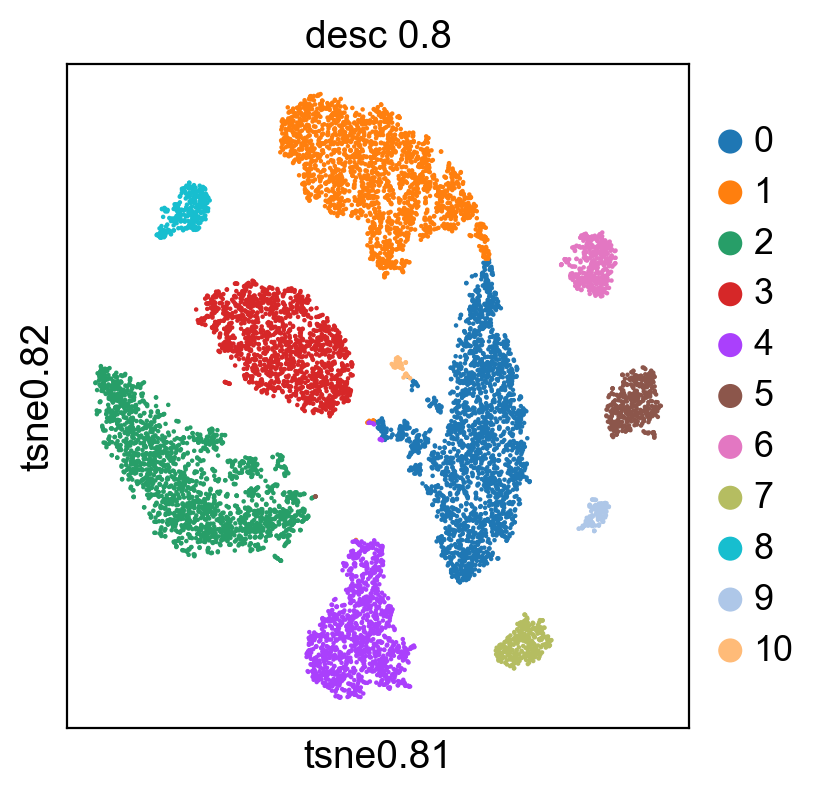

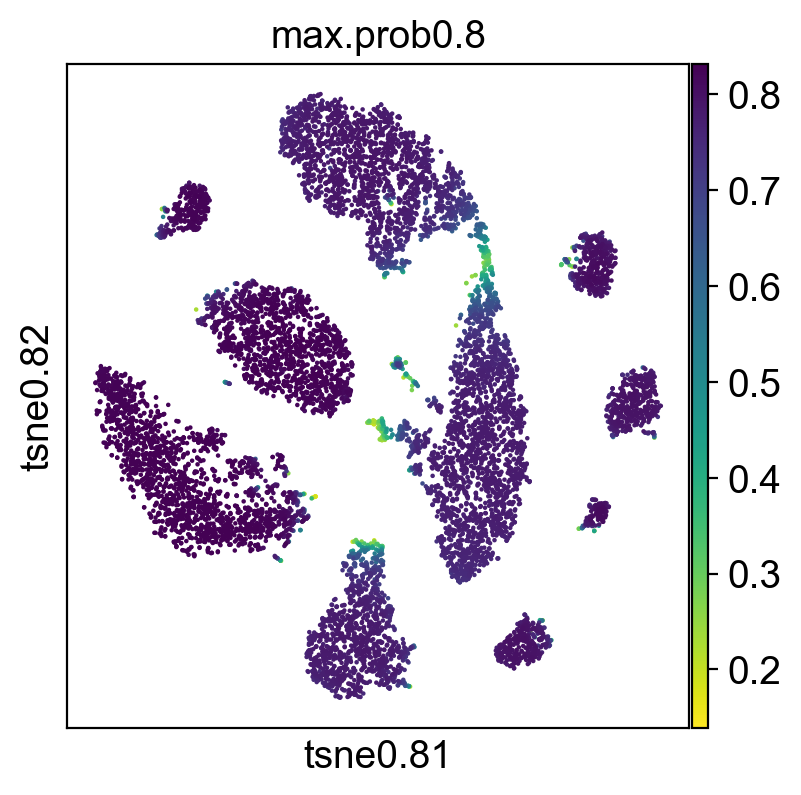

In [156]:
prob_1=adata.uns["prob_matrix0.8"]
adata.obs["max.prob0.8"]=np.max(prob_1,axis=1)
#tSNE plot 
sc.pl.scatter(adata,basis="tsne0.8",color=['desc_0.8'])
sc.pl.scatter(adata,basis="tsne0.8",color=["max.prob0.8"], legend_fontoutline=5)

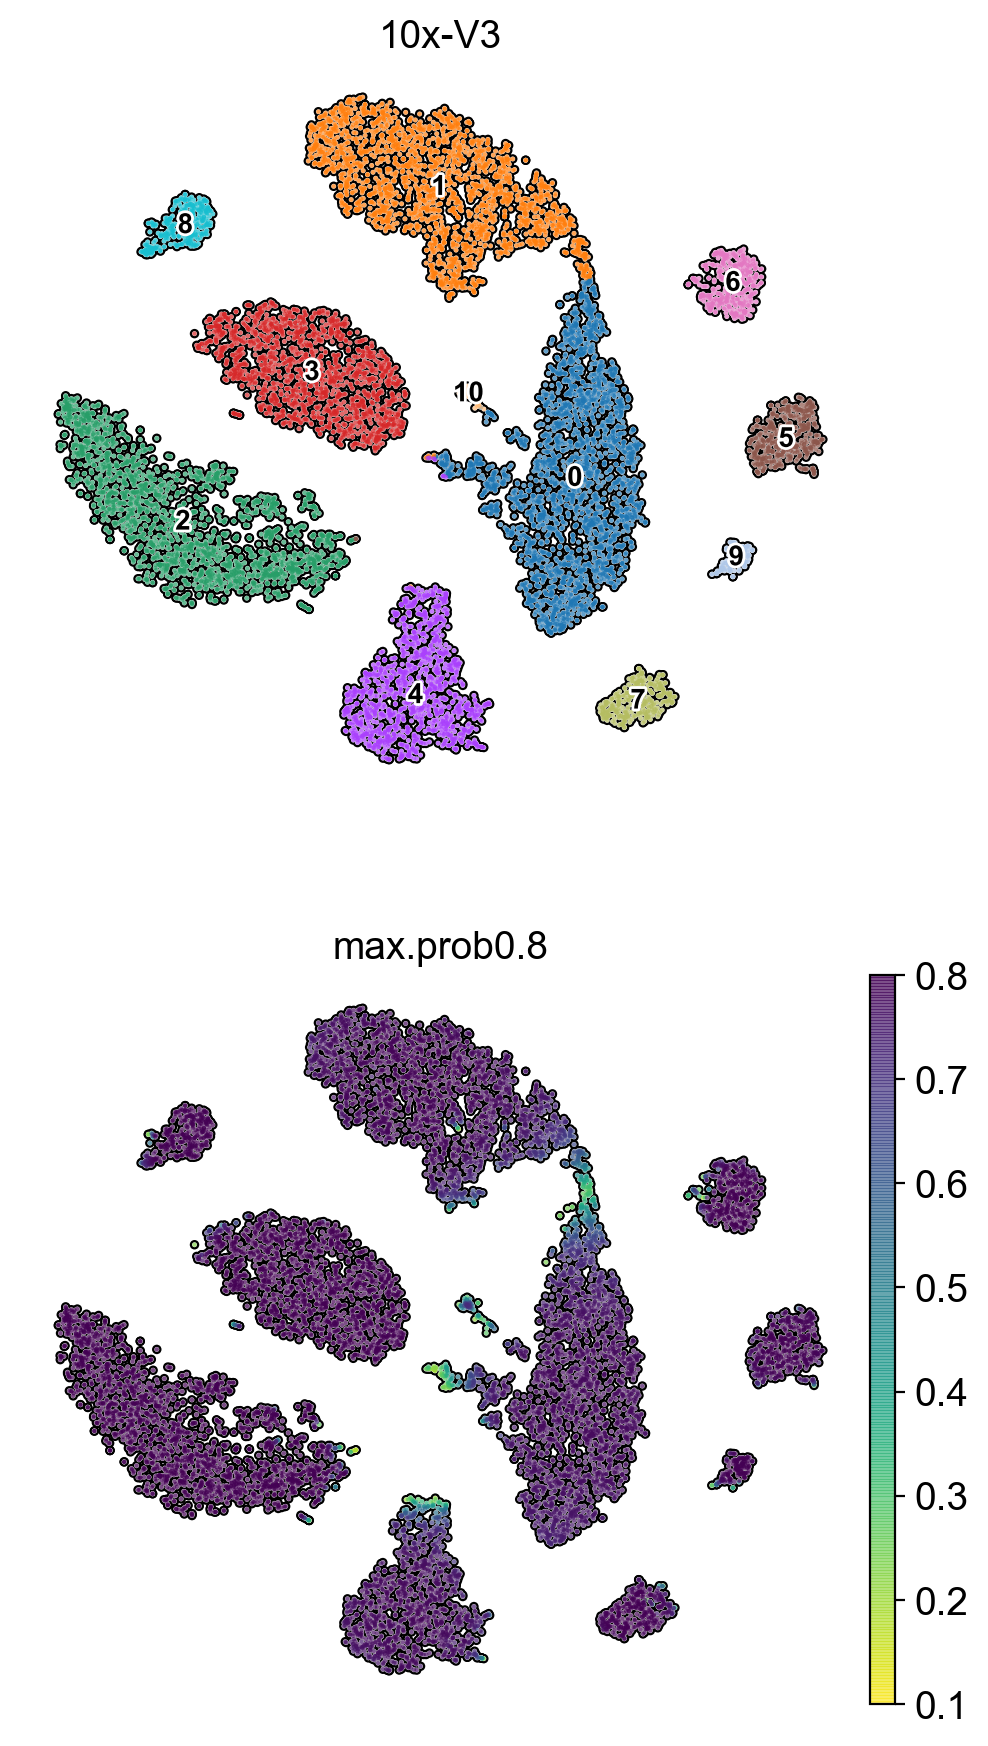

In [157]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.tsne(adata,color=['desc_0.8',"max.prob0.8"], legend_loc='on data',
                  legend_fontsize=10, legend_fontoutline=2,frameon=False, title='10x-V3', 
               add_outline=True, outline_width=(0.5, 0.05), vmin=0.1,vmax=0.8, ncols=1, 
               save='DESC_Control_Res0.8_TSNE_Prrobabilities.png')
    


# scCLEAN 

Repeat the exact same framework except switching out the input file from Control to scCLEAN

In [158]:
#input the cellranger output h5ad file from alignment to the full transcriptome
data = desc.read_h5ad('raw_files/FUll_transcriptome/Dep_rep3_not_masked_filtered_feature_bc_matrix.h5ad')
data.var_names_make_unique()
data

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 11786 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [159]:
sc.pp.filter_cells(data, min_counts=500)
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=3)

filtered out 248 cells that have less than 200 genes expressed
filtered out 15160 genes that are detected in less than 3 cells


In [160]:
mito_genes = data.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
data.obs['percent_mito'] = np.sum(
    data[:, mito_genes].X, axis=1).A1 / np.sum(data.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
data.obs['n_counts'] = data.X.sum(axis=1).A1

In [161]:
#determine the proper thresholds according to the 99% of the data
per_cell_metrics = data.obs
dquantile = pd.DataFrame()
dquantile = per_cell_metrics.quantile(0.99, numeric_only=True)
dquantile

n_counts        13217.910000
n_genes          4809.150000
percent_mito        0.001973
Name: 0.99, dtype: float64

Remember the overall counts are lower in the scCLEAN condition because 250 protein coding genes were targeted for removal, and reads were re-distributed to lower expressed transcripts. Consequently, the UMIs associated with housekeeping genes were removed. 

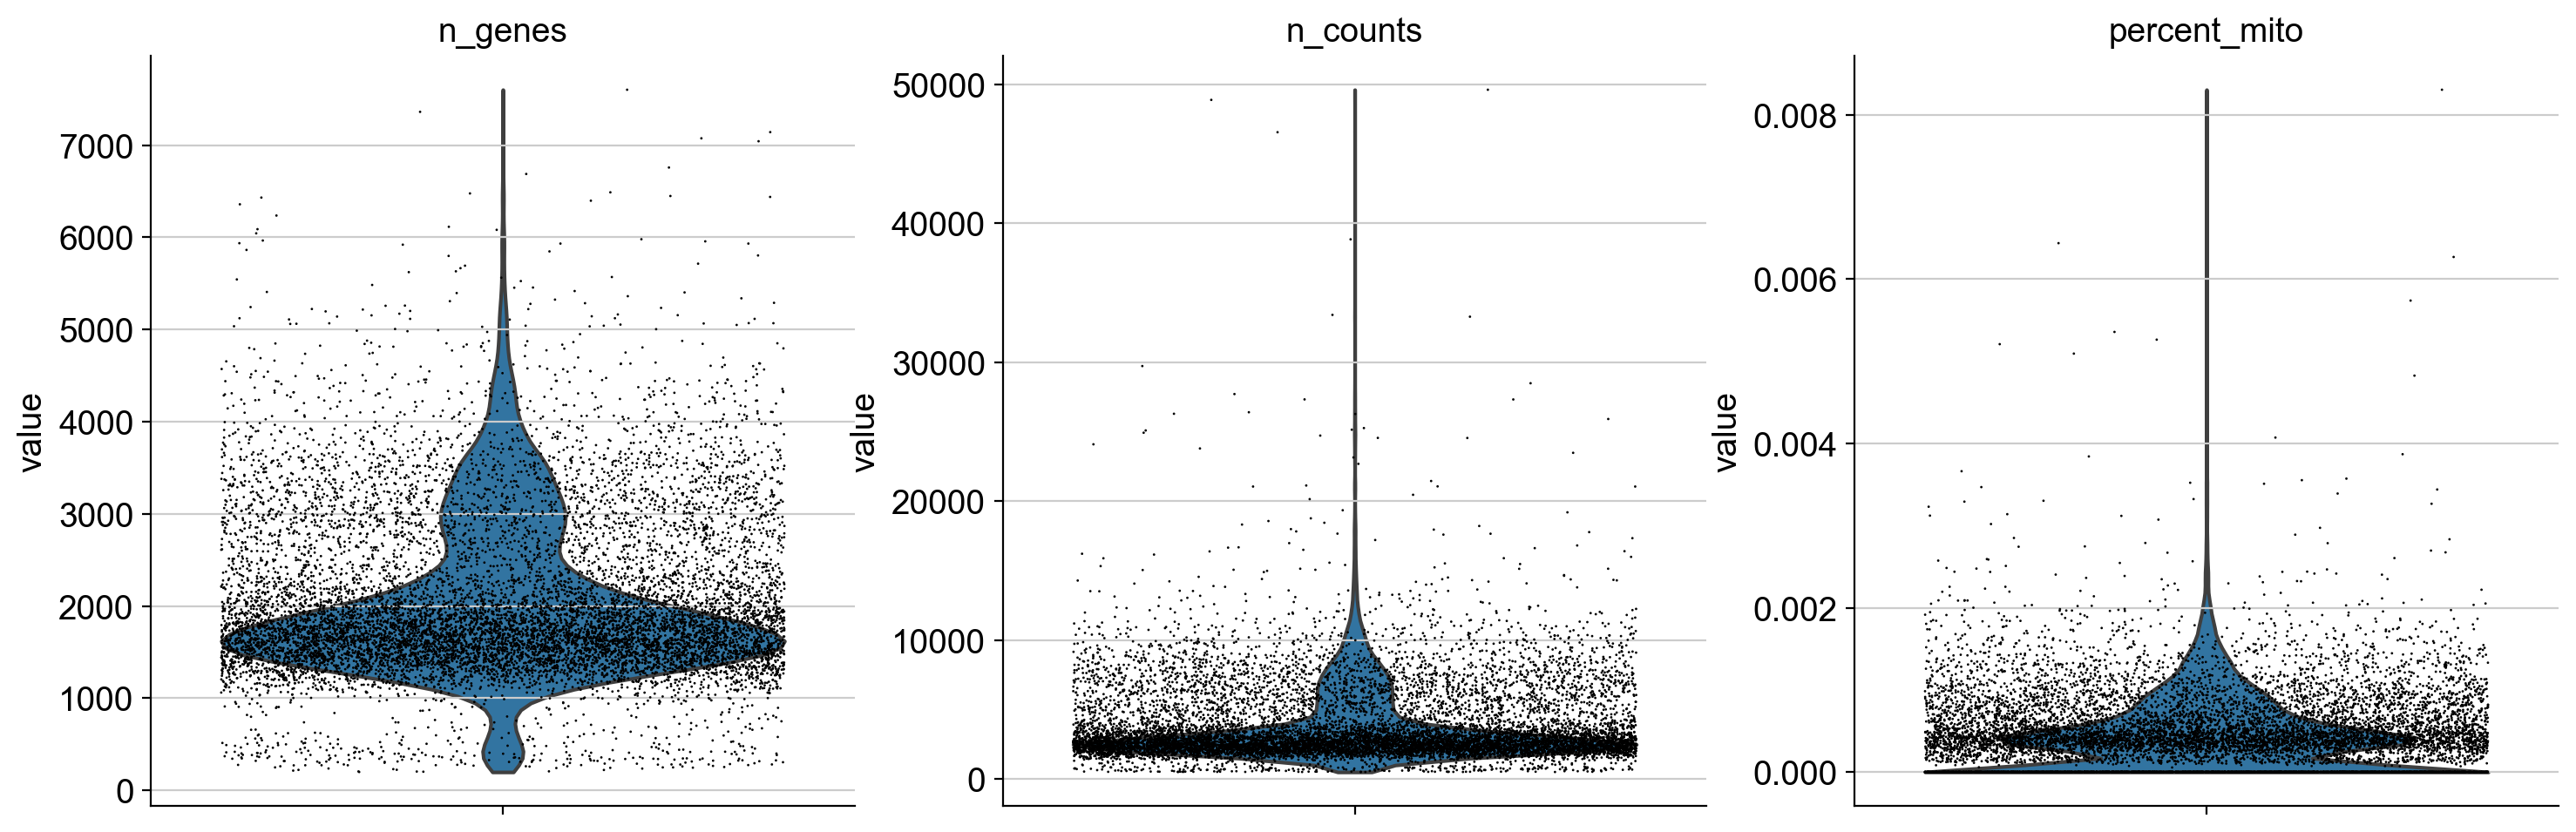

In [162]:
sc.pl.violin(data, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True)

In [163]:
#filter thresholds from 99% 
data = data[data.obs['n_counts'] < 13217.910000, :]
data

View of AnnData object with n_obs × n_vars = 11422 × 21441
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [164]:
desc.normalize_per_cell(data, counts_per_cell_after=1e4)

normalizing by total count per cell
Trying to set attribute `.obs` of view, copying.
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [165]:
desc.log1p(data)

In [166]:
data.raw=data

In [167]:
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5, subset=True)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [168]:
data = data[:, data.var['highly_variable']]
data

View of AnnData object with n_obs × n_vars = 11422 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [169]:
desc.scale(data, zero_center=True, max_value=3)

/Users/jbezney/opt/anaconda3/envs/DESC/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [44]:
#loop through the deep learning model and append the total number of clusters identified
#check the total number of clusters according to the resolution with which it was identified
resolution_x = [0.1,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
dep_total_clusters = []
for value in resolution_x:
    data = desc.train(data, dims=[data.shape[1], 128, 32], tol=0.001, n_neighbors=10,
                   batch_size=256, louvain_resolution=[value], do_tsne=True, learning_rate=300,
                   do_umap=True, num_Cores_tsne=4)
    df_cluster = pd.DataFrame(data.obs['desc_'+str(value)])
    df_cluster = len(df_cluster.iloc[:,0].unique())
    dep_total_clusters.append(df_cluster)

Start to process resolution= 0.1
The number of cpu in your computer is 12
Create the directory:result_tmp to save result
Checking whether result_tmp/ae_weights.h5  exists in the directory
The file ae_weights.h5 is not exits
Pretraining the 1th layer...
learning rate = 0.1
Epoch 1/50
45/45 [==============================] - 1s 7ms/step - loss: 0.4919
Epoch 2/50
45/45 [==============================] - 0s 8ms/step - loss: 0.4660
Epoch 3/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4452
Epoch 4/50
45/45 [==============================] - 0s 8ms/step - loss: 0.4307
Epoch 5/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4200
Epoch 6/50
45/45 [==============================] - 0s 8ms/step - loss: 0.4102
Epoch 7/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4020
Epoch 8/50
45/45 [==============================] - 0s 7ms/step - loss: 0.3955
Epoch 9/50
45/45 [==============================] - 0s 8ms/step - loss: 0.3908
Epoch 10/50
45/4

Epoch 50/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3574
learning rate = 0.001
Epoch 1/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3573
Epoch 2/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3574
Epoch 3/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3573
Epoch 4/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3573
Epoch 5/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3574
Epoch 6/50
45/45 [==============================] - 0s 7ms/step - loss: 0.3574
Epoch 7/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3575
Epoch 8/50
45/45 [==============================] - 0s 7ms/step - loss: 0.3574
Epoch 9/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3574
Epoch 10/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3574
Epoch 11/50
45/45 [==============================] - 0s 7ms/step - loss: 0.3574
Epoch 00011: early stopping

Epoch 1/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3541
Epoch 2/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3525
Epoch 3/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3515
Epoch 4/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3508
Epoch 5/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3503
Epoch 6/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3497
Epoch 7/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3492
Epoch 8/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3488
Epoch 9/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3483
Epoch 10/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3479
Epoch 11/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3475
Epoch 12/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3471
Epoch 13/50
45/45 [==============================

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.03449483452985467 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0931
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0702
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0575
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0487
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0420
The value of delta_label of current 2 th iteration is 0.016897215899142008 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 2ms/step - loss: 0.1406
Epoch 2/5
45/45 [==============================] - 0s 2ms/step - loss: 0.1140
Epoch 3/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0950
Epoch 4/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0807
Epoch 5/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0698
The value of delta_label of current 3 th iter

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 8)                 256       
Total params: 277,408
Trainable params: 277,408
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=0.1)is: 87.4849910736084


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:32)
computing neighbors


tsne finished and added X_tsne0.1  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap0.1  into the umap coordinates (adata.obsm)

The run time for all resolution is: 121.3835871219635
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11422 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1'
    obsp: 'distances', 'connectivities'
Start to process resolution= 0.2
The number of cpu in your computer is 12
Checking whether result_tmp/ae_weights.h5  exists in the directory
Pretraining time is 0.016829729080200195


computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.038171948870600596 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0946
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0730
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0605
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0516
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0448
The value of delta_label of current 2 th iteration is 0.01645946419191035 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1416
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1159
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0971
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0830
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0722
The value of delta_label of current 3 th iter

computing tSNE


The final prediction cluster is:
0    4271
1    2020
2    1639
3    1785
4     787
5     378
6     300
7     161
8      81
dtype: int64
The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 9)                 288       
Total params: 277,440
Trainable params: 277,440
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=0.2)is: 13.2

    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:30)
computing neighbors


tsne finished and added X_tsne0.2  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap0.2  into the umap coordinates (adata.obsm)

The run time for all resolution is: 44.709169149398804
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11422 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2'
    obsp: 'distances', 'connectivities'
Start to process resolution= 0.4
The number of cpu in your computer is 12
Checking whether result_tmp/ae_weights.h5  exists in the directory
Pretraining time is 0.01116180419921875


computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.04377517072316582 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1021
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0802
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0675
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0585
Epoch 5/5
45/45 [==============================] - 0s 2ms/step - loss: 0.0515
The value of delta_label of current 2 th iteration is 0.031343022237786726 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1564
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1300
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1111
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0967
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0855
The value of delta_label of current 3 th iter

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 11)                352       
Total params: 277,504
Trainable params: 277,504
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=0.4)is: 12.697240114212036


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:29)
computing neighbors


tsne finished and added X_tsne0.4  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap0.4  into the umap coordinates (adata.obsm)

The run time for all resolution is: 42.61803412437439
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11422 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4'
    obsp: 'distances', 'connectivities'
Start to process resolution= 0.6
The number of cpu in your computer is 12
Checking whether result_tmp/ae_weights.h5  exists in the directory
Pretraining time is 0.011688947677612305


computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


The value of delta_label of current 1 th iteration is 0.06478725267028541 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1202
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0987
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0859
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0766
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0692
The value of delta_label of current 2 th iteration is 0.03633339170022763 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1806
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1562
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1380
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1236
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1121
The value of delta_label of current 3 th itera

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 15)                480       
Total params: 277,632
Trainable params: 277,632
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=0.6)is: 15.530126810073853


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:29)
computing neighbors


tsne finished and added X_tsne0.6  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap0.6  into the umap coordinates (adata.obsm)

The run time for all resolution is: 46.4466278553009
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11422 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6'
    obsp: 'distances', 'connectivities'
Start to process resolution= 0.8
The number of cpu in your computer is 12
Checking whether result_tmp/ae_weights.h5  exists in the directory
Pretraining time is 0.010951042175292969


computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.06907721940115566 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1239
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1028
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0902
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0810
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0738
The value of delta_label of current 2 th iteration is 0.03834704955349326 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1844
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1612
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1450
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1320
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1214
The value of delta_label of current 3 th itera

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


0     1545
1     2014
2     1799
3     1387
4      537
5      452
6      951
7      332
8      280
9      310
10    1037
11     278
12     116
13     147
14      57
15      72
16     108
dtype: int64
The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 17)                544       
Total params: 277,696
Trainable params: 277,696
Non-trainable params: 0
_________________________________________

    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:28)
computing neighbors


tsne finished and added X_tsne0.8  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap0.8  into the umap coordinates (adata.obsm)

The run time for all resolution is: 46.80148506164551
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11422 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6', 'desc_0.8'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6', 'prob_matrix0.8'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6', 'X_Embeded_z0.8', 'X_tsne0.8', 'X_umap0.8'
    obsp: 'distances', 'connectivities'
Start to process resolution= 1.0
The number of cpu in your computer is 12
Checking whether result_tmp/ae_weights.h5  exis

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.08220977061810542 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1322
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1118
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0996
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0904
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0829
The value of delta_label of current 2 th iteration is 0.04351251969882682 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1987
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1775
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1613
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1480
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1370
The value of delta_label of current 3 th itera

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The final prediction cluster is:
0     1464
1     2037
2     1306
3     1385
4      786
5      451
6      326
7      350
8      332
9      164
10     311
11     664
12    1122
13     245
14     101
15      45
16      72
17     221
18      25
19      15
dtype: int64
The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 20)                640       
Total params: 277,792
Trainable params: 277,792

    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:28)
computing neighbors


tsne finished and added X_tsne1.0  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap1.0  into the umap coordinates (adata.obsm)

The run time for all resolution is: 45.77424669265747
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11422 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6', 'desc_0.8', 'desc_1.0'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6', 'prob_matrix0.8', 'prob_matrix1.0'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6', 'X_Embeded_z0.8', 'X_tsne0.8', 'X_umap0.8', 'X_Embeded_z1.0', 'X_tsne1.0', 'X_umap1.0'
    obsp: 'distances', 'connectivities'
Start to process resolution= 1.2
The number of 

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.06811416564524601 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1361
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1145
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1021
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0928
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0852
The value of delta_label of current 2 th iteration is 0.044212922430397476 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2037
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1831
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1666
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1532
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1423
The value of delta_label of current 3 th iter

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 20)                640       
Total params: 277,792
Trainable params: 277,792
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=1.2)is: 17.398098945617676


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:28)
computing neighbors


tsne finished and added X_tsne1.2  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap1.2  into the umap coordinates (adata.obsm)

The run time for all resolution is: 46.68986392021179
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11422 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6', 'desc_0.8', 'desc_1.0', 'desc_1.2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6', 'prob_matrix0.8', 'prob_matrix1.0', 'prob_matrix1.2'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6', 'X_Embeded_z0.8', 'X_tsne0.8', 'X_umap0.8', 'X_Embeded_z1.0', 'X_tsne1.0', 'X_umap1.0', 'X_Embeded_z1.2', 'X_tsne1.2', 'X_umap1.2'
    obsp: 'di

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 22 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.09954473822447908 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1402
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1199
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1083
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0993
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0919
The value of delta_label of current 2 th iteration is 0.04797758711258974 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2085
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1892
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1735
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1603
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1493
The value of delta_label of current 3 th itera

Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3034
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3008
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2983
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2958
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2935
The value of delta_label of current 19 th iteration is 0.006828926632813868 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2988
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2965
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2943
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2920
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2899
The value of delta_label of current 20 th iteration is 0.005603221852565225 >= tol 0.001
Epoch 1/5
45/45 [=========================

45/45 [==============================] - 0s 3ms/step - loss: 0.2343
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2341
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2339
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2337
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2335
The value of delta_label of current 53 th iteration is 0.001751006828926633 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2336
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2334
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2332
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2330
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2328
delta_label  0.0007879530730169848 < tol  0.001
Reached tolerance threshold. Stop training.


computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The final prediction cluster is:
0     1941
1     1381
2     2048
3      980
4        5
5      887
6      763
7      449
8      335
9      355
10     329
11     312
12       2
13     635
14     251
15     109
16      46
17      72
18     221
19     256
20      30
21      15
dtype: int64
The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 22)                704       
Total params: 277,856
Tra

    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:29)
computing neighbors


tsne finished and added X_tsne1.4  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap1.4  into the umap coordinates (adata.obsm)

The run time for all resolution is: 80.59438610076904
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11422 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6', 'desc_0.8', 'desc_1.0', 'desc_1.2', 'desc_1.4'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6', 'prob_matrix0.8', 'prob_matrix1.0', 'prob_matrix1.2', 'prob_matrix1.4'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6', 'X_Embeded_z0.8', 'X_tsne0.8', 'X_umap0.8', 'X_Embeded_z1.0', 'X_tsne1.0', 'X_umap1.0', 'X_Embeded_z1.2', 'X_tsne1

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 23 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.1012957450534057 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1405
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1203
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1087
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0999
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0926
The value of delta_label of current 2 th iteration is 0.04403782174750481 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2089
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1900
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1747
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1618
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1511
The value of delta_label of current 3 th iterat

Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3159
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3131
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3104
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3079
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3054
The value of delta_label of current 19 th iteration is 0.0051654701453335665 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3113
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3088
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3065
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3042
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3020
The value of delta_label of current 20 th iteration is 0.004727718438101909 >= tol 0.001
Epoch 1/5
45/45 [========================

45/45 [==============================] - 0s 3ms/step - loss: 0.2432
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2430
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2428
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2425
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2423
The value of delta_label of current 53 th iteration is 0.005253020486779898 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2425
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2423
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2421
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2419
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2417
The value of delta_label of current 54 th iteration is 0.003151812292067939 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso



The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 23)                736       
Total params: 277,888
Trainable params: 277,888
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=1.6)is: 53.03005409240723


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:30)
computing neighbors


tsne finished and added X_tsne1.6  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap1.6  into the umap coordinates (adata.obsm)

The run time for all resolution is: 83.80500197410583
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11422 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6', 'desc_0.8', 'desc_1.0', 'desc_1.2', 'desc_1.4', 'desc_1.6'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6', 'prob_matrix0.8', 'prob_matrix1.0', 'prob_matrix1.2', 'prob_matrix1.4', 'prob_matrix1.6'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6', 'X_Embeded_z0.8', 'X_tsne0.8', 'X_umap0.8', 'X_Embeded_z1.0', 'X_tsne1.0', 'X_umap1.

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 23 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.10488530905270531 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1404
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1198
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1080
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0992
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0919
The value of delta_label of current 2 th iteration is 0.04745228506391175 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2081
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1888
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1734
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1607
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1501
The value of delta_label of current 3 th itera

Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3140
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3112
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3084
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3059
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3033
The value of delta_label of current 19 th iteration is 0.007004027315706532 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3103
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3078
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3053
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3030
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3007
The value of delta_label of current 20 th iteration is 0.004289966730870251 >= tol 0.001
Epoch 1/5
45/45 [=========================

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 23)                736       
Total params: 277,888
Trainable params: 277,888
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=1.8)is: 49.09917163848877


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:30)
computing neighbors


tsne finished and added X_tsne1.8  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap1.8  into the umap coordinates (adata.obsm)

The run time for all resolution is: 80.43619990348816
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11422 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6', 'desc_0.8', 'desc_1.0', 'desc_1.2', 'desc_1.4', 'desc_1.6', 'desc_1.8'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6', 'prob_matrix0.8', 'prob_matrix1.0', 'prob_matrix1.2', 'prob_matrix1.4', 'prob_matrix1.6', 'prob_matrix1.8'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6', 'X_Embeded_z0.8', 'X_tsne0.8', 'X_umap0.8', 'X_Embeded

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 27 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.13920504289966731 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 1s 3ms/step - loss: 0.1458
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1258
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1147
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1062
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0991
The value of delta_label of current 2 th iteration is 0.06741376291367536 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2176
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1994
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1847
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1725
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1621
The value of delta_label of current 3 th itera

45/45 [==============================] - 0s 3ms/step - loss: 0.3320
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3296
Epoch 3/5
45/45 [==============================] - 0s 4ms/step - loss: 0.3269
Epoch 4/5
45/45 [==============================] - 0s 4ms/step - loss: 0.3244
Epoch 5/5
45/45 [==============================] - 0s 4ms/step - loss: 0.3220
The value of delta_label of current 19 th iteration is 0.010768691997898792 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3280
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3257
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3232
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3210
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.3188
The value of delta_label of current 20 th iteration is 0.01006828926632814 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s

45/45 [==============================] - 0s 3ms/step - loss: 0.2564
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2561
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2558
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2555
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2553
The value of delta_label of current 53 th iteration is 0.008755034144633165 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2555
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2552
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2550
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2547
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.2545
The value of delta_label of current 54 th iteration is 0.015146209070215374 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso



The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 27)                864       
Total params: 278,016
Trainable params: 278,016
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=2.0)is: 70.00197196006775


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:29)
computing neighbors


tsne finished and added X_tsne2.0  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap2.0  into the umap coordinates (adata.obsm)

The run time for all resolution is: 100.4626030921936
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11422 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.1', 'desc_0.2', 'desc_0.4', 'desc_0.6', 'desc_0.8', 'desc_1.0', 'desc_1.2', 'desc_1.4', 'desc_1.6', 'desc_1.8', 'desc_2.0'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.4', 'prob_matrix0.6', 'prob_matrix0.8', 'prob_matrix1.0', 'prob_matrix1.2', 'prob_matrix1.4', 'prob_matrix1.6', 'prob_matrix1.8', 'prob_matrix2.0'
    obsm: 'X_Embeded_z0.1', 'X_tsne', 'X_tsne0.1', 'X_umap', 'X_umap0.1', 'X_Embeded_z0.2', 'X_tsne0.2', 'X_umap0.2', 'X_Embeded_z0.4', 'X_tsne0.4', 'X_umap0.4', 'X_Embeded_z0.6', 'X_tsne0.6', 'X_umap0.6', 'X_Embeded_z0.8', 'X_tsn

In [45]:
dep_total_clusters

[8, 9, 11, 15, 17, 20, 20, 22, 22, 23, 25]

In [170]:
#go back and pick a resolution in the middle (0.8) to highlight 
data = desc.train(data, dims=[data.shape[1], 128, 32], tol=0.001, n_neighbors=10,
                   batch_size=256, louvain_resolution=0.8, do_tsne=True, learning_rate=300,
                   do_umap=True, num_Cores_tsne=4)

Start to process resolution= 0.8
The number of cpu in your computer is 12
Create the directory:result_tmp to save result
Checking whether result_tmp/ae_weights.h5  exists in the directory
The file ae_weights.h5 is not exits
Pretraining the 1th layer...
learning rate = 0.1
Epoch 1/50
45/45 [==============================] - 1s 7ms/step - loss: 0.4919
Epoch 2/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4660
Epoch 3/50
45/45 [==============================] - 0s 8ms/step - loss: 0.4452
Epoch 4/50
45/45 [==============================] - 0s 8ms/step - loss: 0.4307
Epoch 5/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4200
Epoch 6/50
45/45 [==============================] - 0s 6ms/step - loss: 0.4102
Epoch 7/50
45/45 [==============================] - 0s 6ms/step - loss: 0.4020
Epoch 8/50
45/45 [==============================] - 0s 7ms/step - loss: 0.3955
Epoch 9/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3908
Epoch 10/50
45/4

Epoch 50/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3574
learning rate = 0.001
Epoch 1/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3573
Epoch 2/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3574
Epoch 3/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3573
Epoch 4/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3573
Epoch 5/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3574
Epoch 6/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3574
Epoch 7/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3575
Epoch 8/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3574
Epoch 9/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3574
Epoch 10/50
45/45 [==============================] - 0s 8ms/step - loss: 0.3574
Epoch 11/50
45/45 [==============================] - 0s 8ms/step - loss: 0.3574
Epoch 00011: early stopping

Epoch 1/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3541
Epoch 2/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3525
Epoch 3/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3515
Epoch 4/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3508
Epoch 5/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3503
Epoch 6/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3497
Epoch 7/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3492
Epoch 8/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3488
Epoch 9/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3483
Epoch 10/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3479
Epoch 11/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3475
Epoch 12/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3471
Epoch 13/50
45/45 [==============================

computing neighbors


...number of clusters is unknown, Initialize cluster centroid using louvain method


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


The value of delta_label of current 1 th iteration is 0.06907721940115566 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1239
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1028
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0902
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0810
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.0738
The value of delta_label of current 2 th iteration is 0.03834704955349326 >= tol 0.001
Epoch 1/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1844
Epoch 2/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1612
Epoch 3/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1450
Epoch 4/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1320
Epoch 5/5
45/45 [==============================] - 0s 3ms/step - loss: 0.1214
The value of delta_label of current 3 th itera

computing tSNE
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


The final prediction cluster is:
0     1545
1     2014
2     1799
3     1387
4      537
5      452
6      951
7      332
8      280
9      310
10    1037
11     278
12     116
13     147
14      57
15      72
16     108
dtype: int64
The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2132)]            0         
_________________________________________________________________
encoder_0 (Dense)            (None, 128)               273024    
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                4128      
_________________________________________________________________
clustering (ClusteringLayer) (None, 17)                544       
Total params: 277,696
Trainable params: 277,696
Non-trainable params: 0
________

    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:32)
computing neighbors


tsne finished and added X_tsne0.8  into the umap coordinates (adata.obsm)



    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


umap finished and added X_umap0.8  into the umap coordinates (adata.obsm)

The run time for all resolution is: 122.48604488372803
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 11422 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.8'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.8'
    obsm: 'X_Embeded_z0.8', 'X_tsne', 'X_tsne0.8', 'X_umap', 'X_umap0.8'
    obsp: 'distances', 'connectivities'


In [171]:
data

AnnData object with n_obs × n_vars = 11422 × 2132
    obs: 'n_counts', 'n_genes', 'percent_mito', 'desc_0.8'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'umap', 'prob_matrix0.8'
    obsm: 'X_Embeded_z0.8', 'X_tsne', 'X_tsne0.8', 'X_umap', 'X_umap0.8'
    obsp: 'distances', 'connectivities'

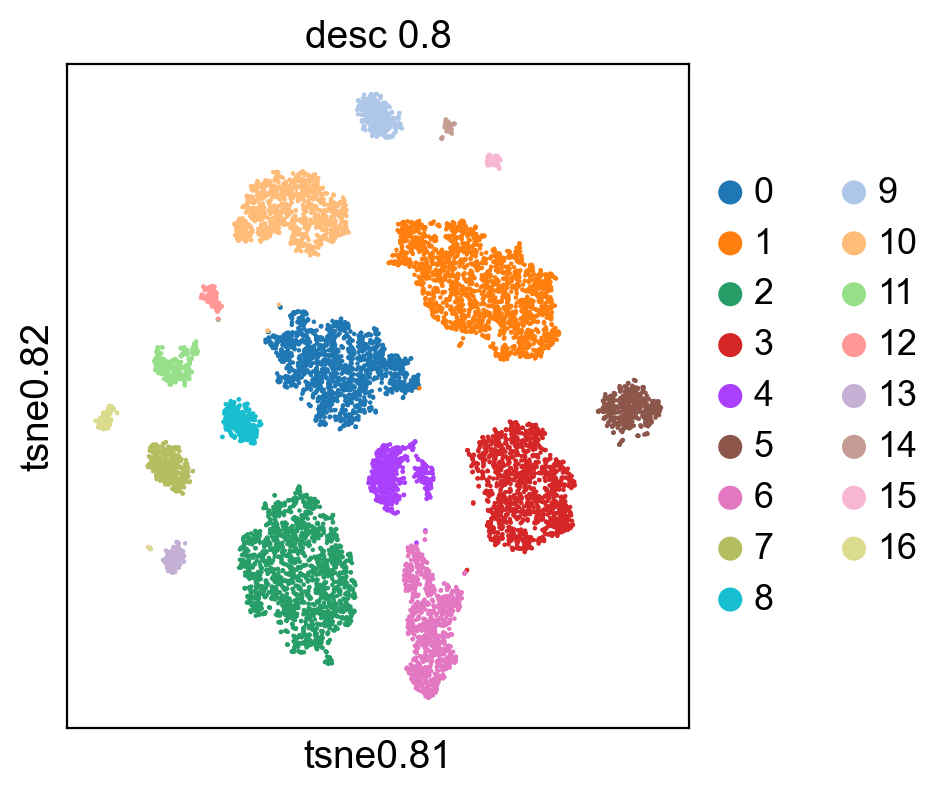

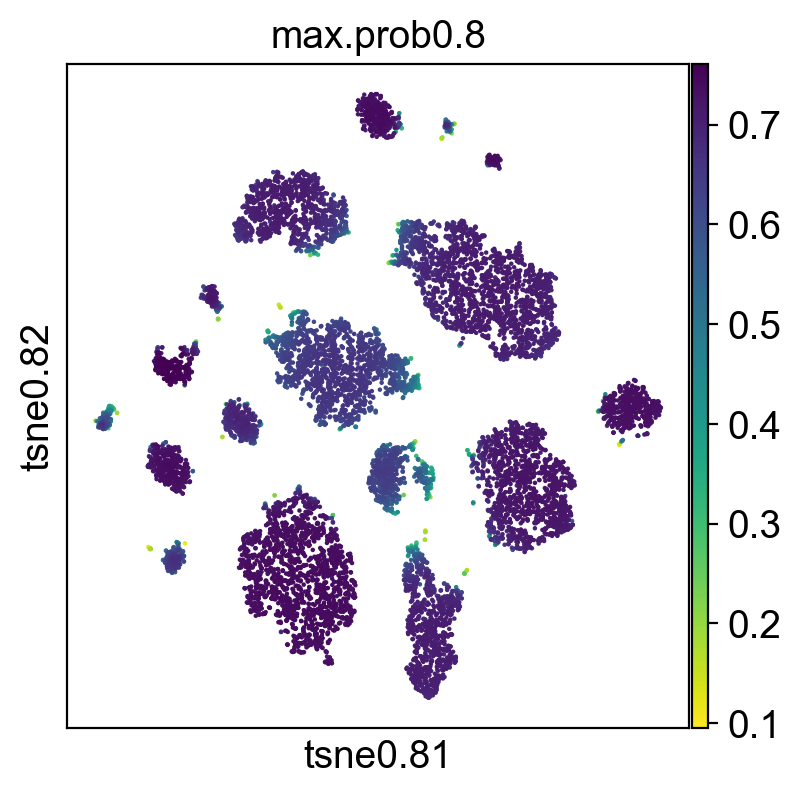

In [172]:
prob_1=data.uns["prob_matrix0.8"]
data.obs["max.prob0.8"]=np.max(prob_1,axis=1)
#tSNE plot 
sc.pl.scatter(data,basis="tsne0.8",color=['desc_0.8'])
sc.pl.scatter(data,basis="tsne0.8",color=["max.prob0.8"], legend_fontoutline=5)

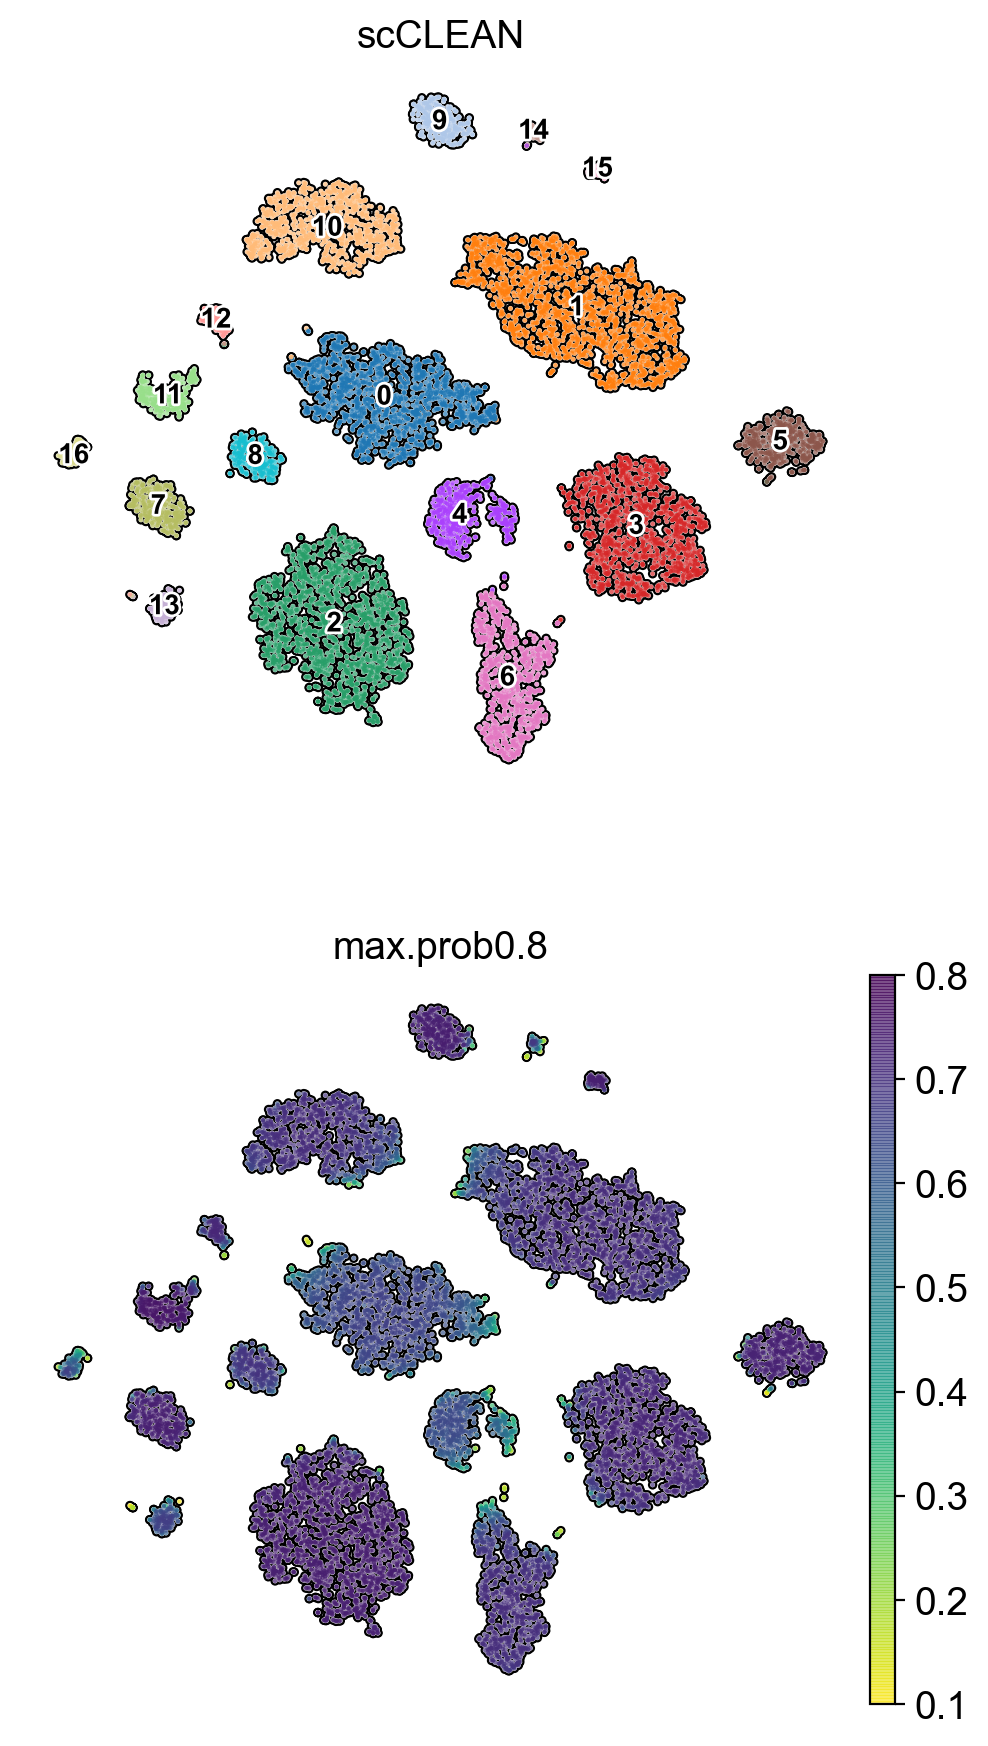

In [173]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.tsne(data,color=['desc_0.8',"max.prob0.8"], legend_loc='on data',
                  legend_fontsize=10, legend_fontoutline=2,frameon=False, title='scCLEAN', 
               add_outline=True, outline_width=(0.5, 0.05), vmin=0.1,vmax=0.8, ncols=1, 
               save='DESC_Depleted_Res0.8_TSNE_Prrobabilities.png')
    
